---------------

__Create__: Yuan.Sh

__Date__: 2021-11-30 22:29:26

__Email__: yuansh3354@163.com

__Blog__: https://blog.csdn.net/qq_40966210

__Address__:Fujian Medical University

__Ref__: https://blog.csdn.net/qq_40966210/article/details/114052720

---------------

In this section, The DEGs will find in four groups.

- Absolute
- Article
- CaSee
- inferCNV

How to define Article-label && inferCNV label were described in the previous section.

Absolute was define follow the rule:

**Pseudo code：**

```
if Article=='Cancer' && CaSee=='Cancer'：
    Absolute='Cancer'
elseif Article=='Normal' && CaSee=='Normal':
    Absolute='Normal'
else:
    Absolute='Others'
```

In [1]:
### import packages 
import os
import math
import itertools
import warnings
import numpy as np
import glob 
import pandas as pd
from collections import Counter
import multiprocessing
import matplotlib.pyplot as plt
from PIL import Image
import scanpy as sc
import re 

### setting plot args
%matplotlib inline
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['savefig.dpi'] = 100 #图片像素
plt.rcParams['figure.dpi'] = 100 #分辨率
warnings.filterwarnings("ignore")

### loading datasets
meta = pd.read_csv('../GSE131907_epi_meta.csv',index_col=0)
predict = pd.read_csv('../merge_data_h5_file/merge_data_predict_Integration_.csv',index_col=0)
expr = pd.read_hdf('../merge_data_h5_file/merge_data_Candidate_cancer_expr.h5',key='expr')
ids = expr.index.intersection(meta.index).intersection(predict.index)
len(ids)

36467

**Runing scanpy pipline**

> https://blog.csdn.net/qq_40966210/article/details/114052720


In [2]:
# 1.create scanpy object
cellinfo = pd.DataFrame(expr.index, index=expr.index, columns=['sample_index'])
geneinfo = pd.DataFrame(expr.columns,
                        index=expr.columns,
                        columns=['genes_index'])
cellinfo = pd.concat([cellinfo,meta,predict],axis=1)
sce = sc.AnnData(expr, obs=cellinfo, var=geneinfo)
sce.var_names_make_unique()
sce.obs_names_make_unique()

# 2.clean data calculate some gene information
mt = sce.var_names[sce.var_names.str.match(r'^MT-')]  # 线粒体DNA
rp = sce.var_names[sce.var_names.str.match(r'^RP[SL][0-9]')]  # 核糖体DNA
ercc = sce.var_names[sce.var_names.str.match(r'^ERCC-')]  # 外源DNA
ncRNA = sce.var_names[sce.var_names.str.match(
    r'^[A-Z][A-Z][0-9]*\.[0-9]')]  # 匹配有小数点的基因
LOC = sce.var_names[sce.var_names.str.match(
    r'(^LOC|LINC)[1-9]*')]  # 匹配未知的LC rna

# 3.statistics
print("total number of MT: {}".format(len(mt)))
print("total number of RT: {}".format(len(rp)))
print("total number of ERCC: {}".format(len(ercc)))
print("total number of non-coding RNA: {}".format(len(ncRNA)))
print("total number of LNC_RNA: {}".format(len(LOC)))

# 4.remove genes
ids = list(rp) + list(ercc) + list(ncRNA) + list(LOC) + list(mt)
print("Total Remove Genes {}".format(len(ids)))
use_genes = sce.var.index.values
ids = set(use_genes) - set(ids)
print("Number of use Genes {}".format(len(ids)))
sce = sce[:,sce.var.genes_index.isin(ids)]
sce.obs['cnv.label'].fillna('Others',inplace=True)

# using scale probablity as predict result 
sce.obs['predict'] = sce.obs['scale_predict']

Trying to set attribute `.obs` of view, copying.


total number of MT: 13
total number of RT: 98
total number of ERCC: 0
total number of non-coding RNA: 1418
total number of LNC_RNA: 781
Total Remove Genes 2310
Number of use Genes 27324


In [5]:
# 5.Stander workflow
sc.pp.normalize_total(sce, target_sum=1e6)
sc.pp.log1p(sce)
sce.raw = sce
sc.pp.highly_variable_genes(sce,n_top_genes=2000)
sc.pp.scale(sce)
sc.tl.pca(sce, svd_solver='arpack', use_highly_variable=True)
sc.pp.neighbors(sce,n_pcs=20)
sc.tl.leiden(sce)
sc.tl.tsne(sce,n_jobs=32)

sce.obs.loc[sce.obs['Cell_subtype'].isna(),'article_label'] = 'Unknow'
sce.obs.loc[sce.obs['Cell_subtype'] == 'Undetermined','article_label'] = 'Unknow'

... storing 'Barcode' as categorical
... storing 'Sample' as categorical
... storing 'Sample_Origin' as categorical
... storing 'Cell_type' as categorical
... storing 'Cell_type.refined' as categorical
... storing 'Cell_subtype' as categorical
... storing 'cnv.label' as categorical
... storing 'article_label' as categorical
... storing 'weight_predict' as categorical
... storing 'scale_predict' as categorical
... storing 'Moderate' as categorical
... storing 'predict' as categorical
... storing 'absolute_scale' as categorical


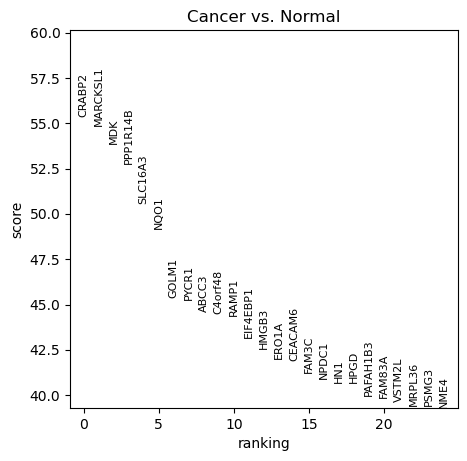

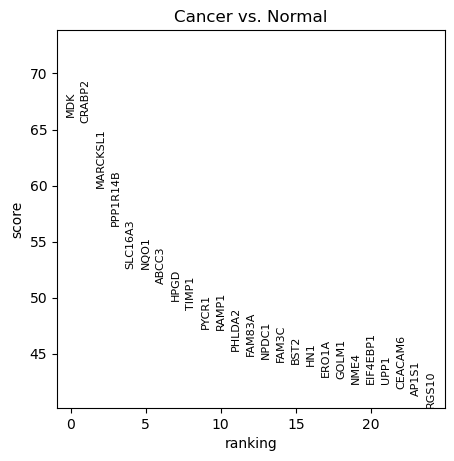

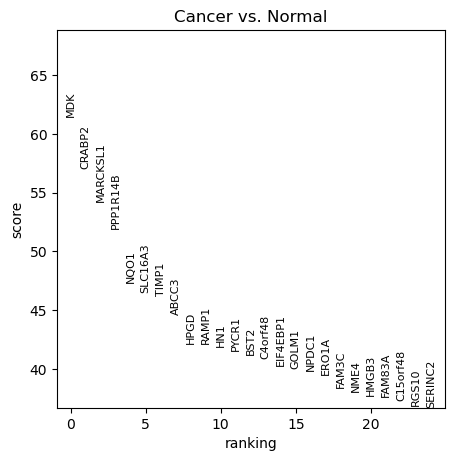

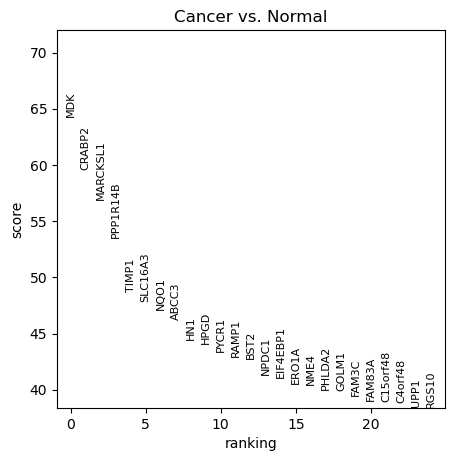

In [9]:
sce.obs['absolute_scale'] = 'other'
sce.obs.loc[(sce.obs['scale_predict'] == 'Cancer') &
            (sce.obs['article_label'] == 'Cancer'), 'absolute_scale'] = 'Cancer'

sce.obs.loc[(sce.obs['scale_predict'] == 'Normal') &
            (sce.obs['article_label'] == 'Normal'), 'absolute_scale'] = 'Normal'



def my_degs(get_type,colname,method):
    sc.tl.rank_genes_groups(sce,colname,groups=[get_type], reference='Normal', method=method)
    sc.pl.rank_genes_groups(sce, n_genes=25, sharey=False)
    p1 = pd.DataFrame(sce.uns['rank_genes_groups']['names'][[get_type]])
    p2 = pd.DataFrame(sce.uns['rank_genes_groups']['logfoldchanges'][get_type])
    p3 = pd.DataFrame(sce.uns['rank_genes_groups']['pvals_adj'][get_type])
    result = pd.concat([p1,p2,p3],axis=1)
    result.columns = ['names','logfoldchanges','pvals_adj']
    # result.head()
    result.to_csv('../' + 'IPA/'+get_type+'_'+colname+'_'+method+'.csv')
    return result

get_type = 'Cancer'
methods = ['logreg', 't-test', 'wilcoxon', 't-test_overestim_var']

ai = my_degs('Cancer','scale_predict','wilcoxon')
cnv = my_degs('Cancer','cnv.label','wilcoxon')
absolute = my_degs('Cancer','absolute_scale','wilcoxon')
article_label = my_degs('Cancer','article_label','wilcoxon')

In [10]:
ai = ai.loc[(abs(ai['logfoldchanges']) > 2) & (ai['pvals_adj']<0.05),]
cnv = cnv.loc[(abs(cnv['logfoldchanges']) > 2) & (cnv['pvals_adj']<0.05),]
absolute = absolute.loc[(abs(absolute['logfoldchanges']) > 2) & (absolute['pvals_adj']<0.05),]
article_label = article_label.loc[(abs(article_label['logfoldchanges']) > 2) & (article_label['pvals_adj']<0.05),]

ai.shape
cnv.shape
absolute.shape
article_label.shape

(3196, 3)

(1848, 3)

(3559, 3)

(3062, 3)

In [11]:
ai[ai['logfoldchanges']>0].shape
ai[ai['logfoldchanges']<=0].shape

cnv[cnv['logfoldchanges']>0].shape
cnv[cnv['logfoldchanges']<=0].shape

absolute[absolute['logfoldchanges']>0].shape
absolute[absolute['logfoldchanges']<=0].shape

article_label[article_label['logfoldchanges']>0].shape
article_label[article_label['logfoldchanges']<=0].shape

(2960, 3)

(236, 3)

(1316, 3)

(532, 3)

(3081, 3)

(478, 3)

(2504, 3)

(558, 3)

In [12]:
len(set(ai['names']).intersection(absolute['names'])) / len(set(ai['names'].append(absolute['names'])))
len(set(cnv['names']).intersection(absolute['names'])) / len(set(cnv['names'].append(absolute['names'])))
len(set(absolute['names']).intersection(absolute['names'])) / len(set(absolute['names'].append(absolute['names'])))
len(set(article_label['names']).intersection(absolute['names'])) / len(set(article_label['names'].append(absolute['names'])))

0.7632471939441399

0.46135135135135136

1.0

0.8070414847161572

In [13]:
ai.to_csv('ai.csv')
cnv.to_csv('cnv.csv')
absolute.to_csv('absolute.csv')
article_label.to_csv('article_label.csv')

In [15]:
Counter(sce.obs['cnv.label'])
Counter(sce.obs['scale_predict'])
Counter(sce.obs['absolute_scale'])
Counter(sce.obs['article_label'])

Counter({'Cancer': 31136, 'Normal': 5331})

Counter({'Normal': 5240, 'Cancer': 31227})

Counter({'other': 3713, 'Cancer': 29644, 'Normal': 3110})

Counter({'Cancer': 31136, 'Normal': 3643, 'Unknow': 1688})